# Preamble

## Library Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import os
import re
from io import StringIO

# Matplotlib stuff
import matplotlib.pyplot as plt

# Less common libraries
import pdfplumber
import wget


## Installation code

In [3]:
# !pip install pdfplumber # Install pdfplumber
# !pip install wget       # Install wget

## Paths

In [6]:
program_root = f"..{os.sep}..{os.sep}..{os.sep}"
project_root = f"..{os.sep}"
data_root    = f"{program_root}Data/"
data_path    = f"{data_root}IE_ESRI{os.sep}PTSB-ESRI_HousePriceIndex{os.sep}"
temp_path = f"{data_root}Temp{os.sep}"
figure_path  = f"{project_root}Figures{os.sep}"

#data_path = f"..{os.sep}..{os.sep}Data{os.sep}"

In [8]:
os.listdir(data_root)

['GB-NIR_NISRA',
 'IE_AA',
 'DataApplications',
 'API_keys',
 'Temp',
 'WorldBank',
 'Core-1626862649056.zip',
 '.DS_Store',
 'IE_CSO',
 'US_IMDB',
 'NewspaperArchive',
 'IE_ESRI',
 'IE_RC',
 'ThemeIndex',
 'AutoAddress_Eircodes',
 'IE_CB',
 'IE_OSI',
 'US_BoxOfficeMojo',
 '.ipynb_checkpoints',
 'IE_PPR',
 'Intermediates',
 'HBS',
 'US_FRED',
 'EU_HFCS',
 'IE_MetEireann',
 'Daft',
 'DHLG&H',
 'Eurostat']

## Functions

In [4]:
def fetch_file(url, file_path):
    # Check if the file is cached locally, if not fetch it
    if not os.path.isfile(file_path):
        print("File not found. Fetching...")    
        wget.download(url,file_path)
        print()
    else:
        print("File found locally.")
    return pdfplumber.open(file_path)


In [5]:
def perform_regex(page):
    # Data that comes out of the PDF is in a somewhat messy but constant format; 
    # use regex to fix the bulk stuff
    page = re.sub(r"Outside\s*\nDublin", r"OutsideDublin", page)   # Extra line for space
    page = re.sub(r"\s*(\d+),(\d+)", r",\1\2", page)               # Numbers with thousands
    page = re.sub(r"\s*(\d+)\s*(\d+\.\d+)(\s+)", r",\1\2\3", page) # Weird splits in decimals
    page = re.sub(r"\s*(-?\d+\.\d+%)", r",\1", page)               # Percentages
    page = re.sub(r" (Q[1-4])\s*([0-9]{4})", r",\2\1", page)       # Redo quarters
    page = re.sub(r"\s+,", r",", page)                             # Replace extra spaces
    return page

In [6]:
def fix_final_page(line_list):
    # Remove extra data at the end of the last page and return separately
    # First line is still separated by spaces
    split_line = line_list[0].split(" ")
    extra_data = {'label' : " ".join(split_line[1:])}
    revised_list = [split_line[0]]

    # Following three lines are comma separated
    for line_num in range(1,4):
        split_line = line_list[line_num].split(",")
        revised_list.append(",".join(split_line[:-1]))
        extra_data[split_line[0]] = split_line[-1]
    
    revised_list += line_list[4:]
        
    return revised_list, extra_data

In [7]:
def process_line_list(line_list):
    # File repeats headers for each section, instead we can prefix the column 
    # with the section name
    temp_list = ['YQ' + line_list[0][5:]]
    for i in range(5):
        prefix = line_list[i*4].split(",")[0]
        temp_list += [f"{prefix}_{line}" for line in line_list[(i*4)+1:(i+1)*4]]
    return temp_list


In [8]:
def fix_first_page(line_list):
    # Pad initial quarters for rates on first page
    for i in range(4,7):
        line_list[i] = ",".join([line_list[i].split(",")[0]] + ["NaN"] + line_list[i].split(",")[1:])
    for i in range(7,13):
        line_list[i] = ",".join([line_list[i].split(",")[0]] + ["NaN"]*4 + line_list[i].split(",")[1:])
    return line_list

In [9]:
def create_df(page):
    # Treat the data as a CSV file and then convert to a dataframe and transpose
    page_df = pd.read_csv(StringIO(page)).T
    
    # Convert the first column into data and the first row into column headers
    page_df.reset_index(inplace=True)
    page_df = page_df.rename(columns=page_df.iloc[0]).drop(page_df.index[0])
    page_df.reset_index(inplace=True, drop=True)
    
    return page_df

In [10]:
def fix_price_issue(full_df):
    # There is an error with the prices in 2008Q4 / 2009Q1 that seeemed too awkward to 
    # fix in regex, fixing in dataframe
    places = ['Dublin', 'OutsideDublin', 'National']
    for place in places:
        corrections = full_df.loc[full_df['YQ'] == '2008Q4', f"Prices_{place}"].values[0].split()
        rest = full_df.loc[full_df['YQ'] == '2009Q1', f"Prices_{place}"].values[0]
        full_df.loc[full_df['YQ'] == '2008Q4', f"Prices_{place}"] = corrections[0]
        full_df.loc[full_df['YQ'] == '2009Q1', f"Prices_{place}"] = corrections[1] + rest
    return full_df

In [11]:
def process_page(pdf, page_num):
    # Take a page from the pdf and turn it into a formatted dataframe
    page = pdf.pages[page_num].extract_text()
    
    # First we 
    page = perform_regex(page)
    line_list = page.split("\n")[1:]
    # Final page has some extra data we want to keep
    peak_dict = {}
    if page_num == (len(pdf.pages) - 1):
        line_list, peak_dict = fix_final_page(line_list)
    # 
    line_list = process_line_list(line_list)
    # First page has unmarked nulls in three of the series
    if page_num == 0:
        line_list = fix_first_page(line_list)
    page = "\n".join(line_list)
    
    # Convert to dataframe and return
    return create_df(page), peak_dict


In [12]:
def clean_df(full_df):
    # Convert the dataframe from wide to long, reformat the percentage change columns and 
    # make names easier to read    
    full_df = fix_price_issue(full_df)
    
    stubs = ['Index', 'Qtrly', 'YOY', 'YTD', 'Prices']
    full_df = pd.wide_to_long(full_df, stubs, i="YQ", j="Place", sep="_", suffix=r'\w+')
    # Key here was the need for the regex to find the suffix, found in the docs:
    #   [ https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html ]
    full_df.reset_index(inplace=True)
    full_df.columns = ['YQ', 'Place', 'Index', 'QuarterlyChange(%)',
                       'YearOnYearChange(%)', 'YearToDateChange(%)', 'Price']
    for column in full_df.columns[2:]:
        if column in ['Index','Price']:
            full_df[column] = pd.to_numeric(full_df[column])
        else:
            full_df[column] = pd.to_numeric(full_df[column].str[:-1])
    # for column in ['Index', 'Price']:
    #     full_df[column] = pd.to_numeric(full_df[column])
    # for column in ['QuarterlyChange(%)', 'YearOnYearChange(%)', 'YearToDateChange(%)']:
    #     
    return full_df

In [13]:
def process_pdf(url = "http://www.irishlifeandpermanent.ie/~/media/Files/I/Irish-Life-And-Permanent/Attachments/pdf/press-releases/permtsb/permanent-tsb-house-price-index-q410.pdf",
                save_file=True):
    # Convert PDF into dataframe
    file_path = f"{data_path}PTSB-ESRI_HousePriceIndex_2010Q4.pdf"
    pdf = fetch_file(url, file_path)
    
    print("Processing pages...", end=" ")
    for page_num in range(len(pdf.pages)):
        # Via [ https://towardsdatascience.com/how-to-extract-text-from-pdf-245482a96de7 ]
        page_df, peak_dict = process_page(pdf, page_num)
        if page_num == 0:
            full_df = page_df.copy()
        else:
            full_df = pd.concat([full_df, page_df])
    print("Complete.")
    # Clean created dataframe
    full_df = clean_df(full_df)
    if save_file:
        output_filename = f'{data_path}PTSB-ESRI_HousePriceIndex.csv'
        full_df.to_csv(output_filename, index=False)
        print(f"File saved to [{output_filename}]")
    return full_df

In [16]:
def plot_series(df, variable = 'Index'):
    views = {}
    for place in df.Place.unique():
        views[place] = df.loc[df['Place'] == place]
    # variable = 'Index'
    # for place in places:
        plt.plot(views[place]['YQ'],views[place][variable], label=f"{place} ({variable})")

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.set_title("PTSB/ESRI Housing Index, by quarter, 1996Q1 - 2010Q4", fontweight='bold')
    ax.set_xlabel('Time, quarters', fontweight='bold')
    ax.set_ylabel(variable, fontweight='bold')
    ax.grid(linestyle="--")
    ax.set_facecolor('#eeeeee')
    ax.legend()

    fig = plt.gcf()
    fig.patch.set_facecolor('#ffffff')
    fig.set_size_inches(18,6)
    # pyplot.locator_params(nbins=4)
    plt.tight_layout()


# Permanent TSB / ESRI Index:

While the CSO has an index of house prices that dates back to quarter 1 2005, this does not really capture the dynamics of the housing boom. However the ESRI, in conjunction with Irish Life and Permanent (now part of Permanent TSB) created a mix adjusted housing index from quarter 1 1996 to quarter 4 2010. Details of the construction of this index and some analysis is available in a paper from the ESRI. The final release of the [data](http://www.irishlifeandpermanent.ie/~/media/Files/I/Irish-Life-And-Permanent/Attachments/pdf/press-releases/permtsb/permanent-tsb-house-price-index-q410.pdf) (or at least the latest issue I could find) is available from an the [Irish Life and Permanent website](http://www.irishlifeandpermanent.ie/media/press-releases/2011/18-01-2011.aspx)

https://www.esri.ie/publications/esri-permanent-tsb-house-price-index

http://www.irishlifepermanent.ie/~/media/Files/I/Irish-Life-And-Permanent/Attachments/pdf/house-price-reports/house-price-review-presentations/esri_rev

There is more there; [ http://www.irishlifeandpermanent.ie/media/press-releases/2019.aspx ]

This, [ http://www.irishlifeandpermanent.ie/~/media/Files/I/Irish-Life-And-Permanent/Attachments/pdf/press-releases/permtsb/hpi_tables_dec09.pdf ] is the monthly price listing for everything up until the end of 2009

### Main Code

File found locally.
Processing pages... Complete.
File saved to [../../Data/IE_ESRI/PTSB-ESRI_HousePriceIndex/PTSB-ESRI_HousePriceIndex.csv]


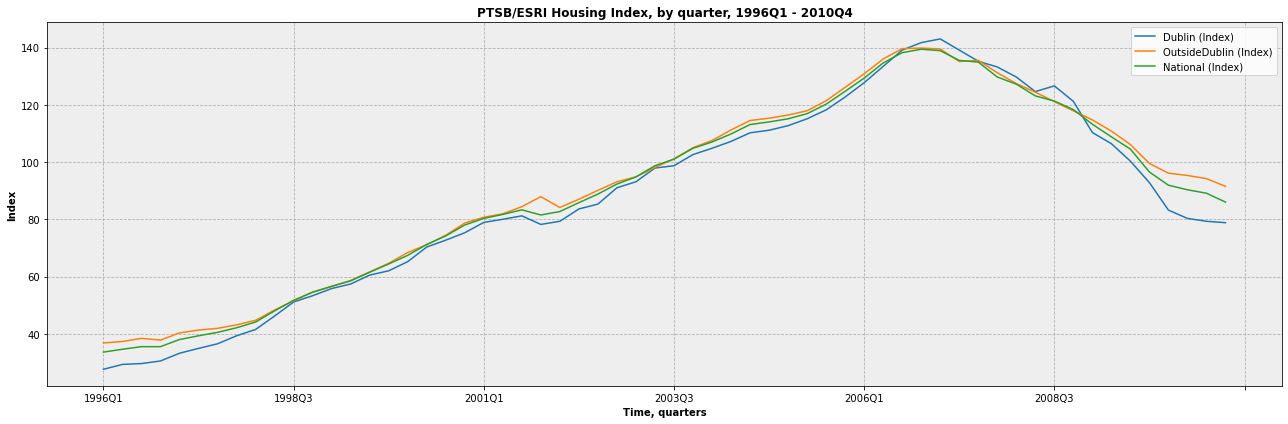

In [17]:
df = process_pdf()
plot_series(df)

### Looking at rate data

In [19]:
views = {}
for place in df.Place.unique():
    views[place] = df.loc[df['Place'] == place].copy()

In [20]:
views['Dublin'].dtypes

YQ                      object
Place                   object
Index                  float64
QuarterlyChange(%)     float64
YearOnYearChange(%)    float64
YearToDateChange(%)    float64
Price                  float64
dtype: object

In [21]:
df['QC'] = round(views['Dublin']['Price'].diff() / views['Dublin']['Price'].shift(1) * 100,1) # Quarterly change
df['YOY'] = round(views['Dublin']['Price'].diff(4) / views['Dublin']['Price'].shift(4) * 100,1) # Year on Year Change
# df['YTD'] = round(views['Dublin']['Price'].diff(4) / views['Dublin']['Price'].shift(4) * 100,1) # Year on Year Change
# Not yet entirely sure what YTD is supposed to capture...
# views['Dublin']['QuarterlyChange(%)','QC2']

Not sure exactly what YTD is supposed to capture...

In [22]:
(105228-83071)/83071

0.26672364603772675

In [ ]:
# views['Dublin']['CumulativePriceChange'] = 

In [23]:
quarter_list = df['YQ'].unique()
first_quarter = quarter_list[0]
final_quarter = quarter_list[-1]
num_quarters = len(quarter_list)
years = num_quarters / 4
for place in df.Place.unique():
    initial_price = df.loc[(df['YQ'] == first_quarter) &
                       (df['Place'] == place)].Price.values[0]
    final_price = df.loc[(df['YQ'] == final_quarter) &
                           (df['Place'] == place)].Price.values[0]
    print(f"{place} : {(final_price - initial_price)/initial_price*100:0.3f}")

Dublin : 185.876
OutsideDublin : 148.721
National : 155.913


In [1222]:
df.loc[df['YQ'] == "1996Q1"]

,YQ,Place,Index,QuarterlyChange(%),YearOnYearChange(%),YearToDateChange(%),Price,QC,YOY
0,1996Q1,Dublin,27.6,NaN,NaN,NaN,83071.0,NaN,NaN
60,1996Q1,OutsideDublin,36.8,NaN,NaN,NaN,70187.0,NaN,NaN
120,1996Q1,National,33.6,NaN,NaN,NaN,74938.0,NaN,NaN


In [1217]:
views['Dublin']

,YQ,Place,Index,QuarterlyChange(%),YearOnYearChange(%),YearToDateChange(%),Price,QC,YOY
0,1996Q1,Dublin,27.6,NaN,NaN,NaN,83071.0,NaN,NaN
1,1996Q2,Dublin,29.3,6.3,NaN,NaN,88270.0,6.3,NaN
2,1996Q3,Dublin,29.6,0.9,NaN,NaN,89091.0,0.9,NaN
3,1996Q4,Dublin,30.5,3.3,NaN,NaN,92028.0,3.3,NaN
4,1997Q1,Dublin,33.2,8.6,20.3,8.6,99957.0,8.6,20.3
5,1997Q2,Dublin,34.9,5.3,19.2,14.3,105228.0,5.3,19.2
6,1997Q3,Dublin,36.5,4.6,23.5,19.6,110054.0,4.6,23.5
7,1997Q4,Dublin,39.3,7.5,28.6,28.6,118311.0,7.5,28.6
8,1998Q1,Dublin,41.5,5.7,25.1,5.7,125037.0,5.7,25.1
9,1998Q2,Dublin,46.2,11.5,32.4,17.8,139360.0,11.5,32.4


## PTSB 2009

In [378]:
file_path = f"{data_path}PTSB-ESRI_HousePriceIndex_2009M12.pdf"
url = "http://www.irishlifeandpermanent.ie/~/media/Files/I/Irish-Life-And-Permanent/Attachments/pdf/press-releases/permtsb/hpi_tables_dec09.pdf"

pdf = fetch_file(url, file_path)

bad_lines = []
good_lines = []
for page_num in range(4):
    page = pdf.pages[page_num].extract_text()
    line_list = page.split("\n")
    
    # Some of the lines are corrupted; fix them...
    if page_num == 0:
        bad_lines += [",,".join(line_list[-4].replace(",","").replace("-","--").replace("----","--").split())[1::2]]
        del line_list[-4]
        line_list = line_list[3:] # Remove header, readded manually below
    elif page_num == 1:
        bad_lines += [",".join(line_list[25].replace(",,","").split())]
        del line_list[25]
        bad_lines += [",,".join(line_list[-4].replace(",","").replace("-","--").replace("----","--").split())[1::2]]
        del line_list[-4]
    elif page_num == 2:
        del line_list[25]
        bad_lines += [",".join(line_list[-4].replace(",,","").split()) + ","]
        del line_list[-4]
    elif page_num == 3:
        bad_lines += [",,".join(line_list[3].replace(",","").replace("-","--").replace("----","--").split())[1::2] + ","*6] 
        del line_list[3]
        line_list = line_list[:-2] # Remove trailer, not needed
    
    for item in line_list:
        split_list = item.replace(",","").split()
        missing = 10 - len(split_list)
        line_str = ",".join(split_list)
        line_str += "," * missing # Pad any rows that are too short
        good_lines += [line_str]
header = ["Date,National,OutsideDublin,Dublin,New,Existing,FTB,STB,Commuter,3BedSemi"]
good_lines = header + good_lines + bad_lines

monthly_df = pd.read_csv(StringIO("\n".join(good_lines)))
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'], format='%b-%y')
monthly_df['year'] = monthly_df['Date'].dt.year
monthly_df['YM'] = monthly_df['Date'].dt.year.astype(str) + "M" + monthly_df['Date'].dt.month.astype(str).str.zfill(1)
monthly_df = monthly_df.sort_values('Date')


File found locally.


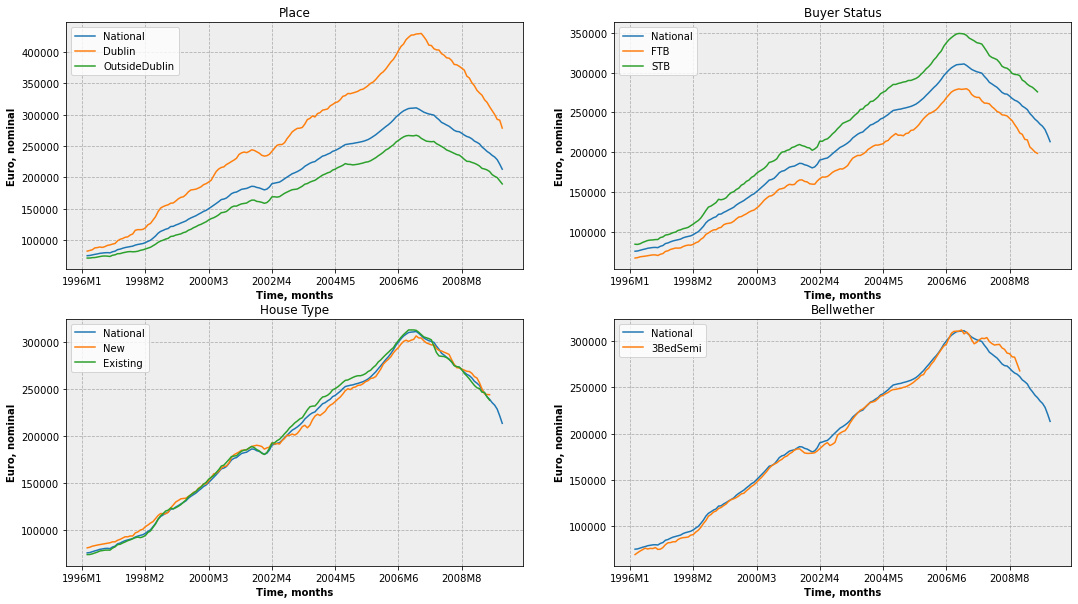

In [379]:
fig, axs = plt.subplots(2,2)

ax = axs[0,0]
columns = ['National', 'Dublin', 'OutsideDublin']
for col in columns:
    ax.plot(monthly_df['YM'], monthly_df[col], label=col)
ax.set_title("Place")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Time, months', fontweight='bold')
ax.set_ylabel('Euro, nominal', fontweight='bold')
ax.grid(linestyle="--")
ax.set_facecolor('#eeeeee')
ax.legend()

ax = axs[0,1]
columns = ['National', 'FTB', 'STB']
for col in columns:
    ax.plot(monthly_df['YM'], monthly_df[col], label=col)
ax.set_title("Buyer Status")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Time, months', fontweight='bold')
ax.set_ylabel('Euro, nominal', fontweight='bold')
ax.grid(linestyle="--")
ax.set_facecolor('#eeeeee')
ax.legend()

ax = axs[1,0]
columns = ['National', 'New', 'Existing']
for col in columns:
    ax.plot(monthly_df['YM'], monthly_df[col], label=col)
ax.set_title("House Type")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Time, months', fontweight='bold')
ax.set_ylabel('Euro, nominal', fontweight='bold')
ax.grid(linestyle="--")
ax.set_facecolor('#eeeeee')
ax.legend()

ax = axs[1,1]
columns = ['National', '3BedSemi']
for col in columns:
    ax.plot(monthly_df['YM'], monthly_df[col], label=col)
ax.set_title("Bellwether")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Time, months', fontweight='bold')
ax.set_ylabel('Euro, nominal', fontweight='bold')
ax.grid(linestyle="--")
ax.set_facecolor('#eeeeee')
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18,10)
# ax.set_title("PTSB/ESRI Housing Index, by quarter, 1996Q1 - 2010Q4", fontweight='bold')

fig.savefig(f"{figure_path}PTSB_Monthly.png")

## ToDo
+ Add link to paper about this
+ ~Link to press release~ _Done_
+ ~Move paths to Json dictionary and default if not there~ _Need to think more about this_
+ ~Add analysis of market in this period~ <= Do this in light of the papers and data in a separate notebook
+ Split into two different notebooks to deal with two different PTSB datasets
+ Add similar notebook for CSO index
+ Add all three to GitHub
+ Look at department of environment link
+ Look at long term growth rates